In [39]:
import numpy as np
import matplotlib.pyplot as plt
# 文字の大きさ
plt.rcParams["font.size"] = 15

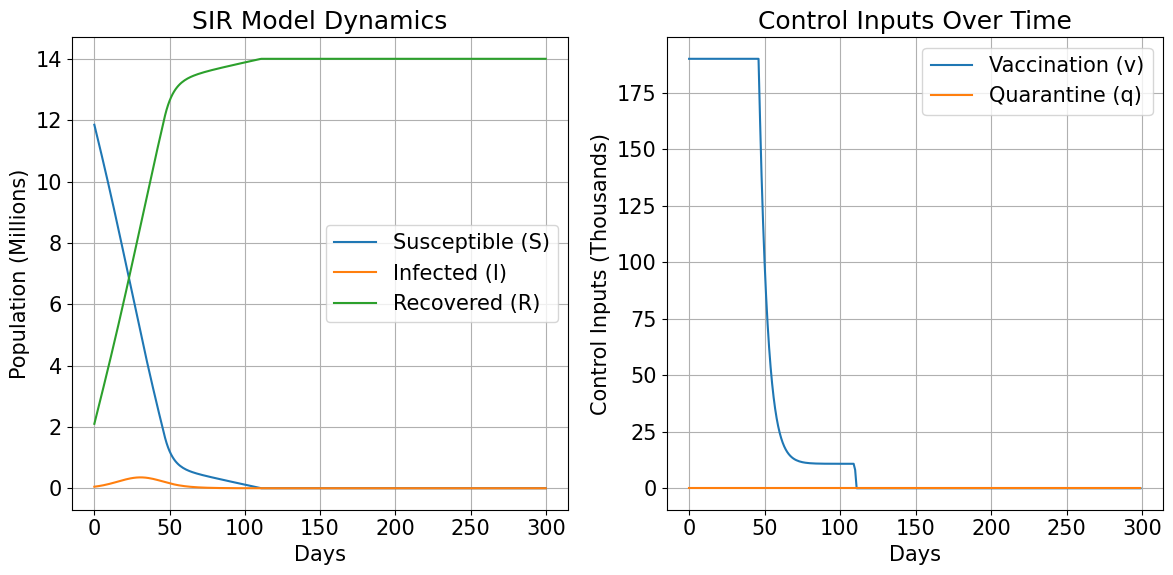

感染収束までの日数: 147 日
合計感染者数: 1369450 人
最大感染者数: 354160 人


In [42]:
USE_VACCINE = True  # ワクチン接種を使うかどうか
USE_QUARANTINE = False # 隔離を使うかどうか




# サフィックスの定義
suffix = ""
suffix += "_v1" if USE_VACCINE else "_v0"  # ワクチン: v1=使用, v0=未使用
suffix += "_q1" if USE_QUARANTINE else "_q0"  # 隔離: q1=使用, q0=未使用



# パラメータ設定
T = 300  # 時間ステップ
dt = 1  # 時間刻み

N = 1.4 * 10**7    # 全人口
I0 = 5000*10            # 初期感染者数 実際の値×10とした．
R0 = N * 0.15             # 初期回復者数
S0 = N - I0 - R0   # 初期の感受性者数

gamma = 0.1        # 回復率
r0 = 2.28        # 基本再生産数
beta = r0 * gamma / S0  # 伝染率

V_max = 1.9 * 10**5  # 最大接種数から導出
Q_max = 1443   # 隔離最大量　開放されたホテルの部屋数から導出


# 重みパラメータ
mu_I = 1  # 感染者数のコスト
mu_v = 0.27 * 10/17 # ワクチンコスト 0.159
mu_q = 10/17 # 隔離コスト 0.588
mu_S = 0.001  # 感受性者数のコスト
mu_R = 0.001  # 回復者数のコスト



# 初期化
S = np.zeros(T + 1)
I = np.zeros(T + 1)
R = np.zeros(T + 1)
v = np.zeros(T)
q = np.zeros(T)

lambda_S = np.zeros(T + 1)
lambda_I = np.zeros(T + 1)
lambda_R = np.zeros(T + 1)

# 初期状態と終端条件
S[0], I[0], R[0] = S0, I0, R0

# 終端条件
# 集団免疫率の計算
H_c = 1 - (1 / r0)  # 集団免疫率

# 目標値の設定
S_goal = (1-H_c) * N  # 未感染者の目標 
R_goal = H_c * N  # 回復者の目標 
I_goal = 0        # 感染者は0にする

# 重みパラメータ
w_S = 0.001  # 未感染者の重み
w_I = 1 # 感染者の重み 
w_R = 0.001  # 回復者の重み


# 共役変数の終端条件
lambda_S[-1] = 2 * w_S * (S[-1] - S_goal)
lambda_I[-1] = 2 * w_I * (I[-1] - I_goal)
lambda_R[-1] = 2 * w_R * (R[-1] - R_goal)

# 反復計算
epsilon = 1e-3  # 収束条件
max_iter = 100  # 最大反復回数
for iteration in range(max_iter):
    # 逆向きに共役変数を更新
    for t in reversed(range(T)):
        # 共役変数の更新
        lambda_S[t] = lambda_S[t + 1] - mu_S + beta * I[t] * (lambda_I[t + 1] - lambda_S[t + 1])
        lambda_I[t] = lambda_I[t + 1] + 2 * mu_I * I[t] + beta * S[t] * (lambda_I[t + 1] - lambda_S[t + 1]) + gamma * (lambda_R[t + 1] - lambda_I[t + 1])
        lambda_R[t] = lambda_R[t + 1] - mu_R
        

    # 順方向に状態を更新
    prev_v = v.copy()
    prev_q = q.copy()
    for t in range(T):
        # 最適制御入力の計算
        
        if USE_VACCINE:
            v[t] = np.clip((lambda_S[t + 1] - lambda_R[t + 1]) / (2 * mu_v), 0, min(S[t], V_max))
        else:
            v[t] = 0
        if USE_QUARANTINE:
            q[t] = np.clip((lambda_I[t + 1] - lambda_R[t + 1]) / (2 * mu_q), 0, min(I[t], Q_max))
        else:
            q[t] = 0
        
        # 状態遷移 (修正版)
        new_S = S[t] - beta * S[t] * I[t] - v[t]
        new_I = I[t] + beta * S[t] * I[t] - gamma * I[t] - q[t]
        new_R = R[t] + gamma * I[t] + v[t] + q[t]

        # 修正: 調整して総人口保存
        adjustment = N - (new_S + new_I + new_R)

        # 各変数に調整を分配
        S[t + 1] = max(0, new_S + adjustment * (S[t] / N))
        I[t + 1] = max(0, new_I + adjustment * (I[t] / N))
        R[t + 1] = max(0, new_R + adjustment * (R[t] / N))

    # 収束判定
    if np.max(np.abs(v - prev_v)) < epsilon and np.max(np.abs(q - prev_q)) < epsilon:
        break

# 結果のプロット# 時間軸
time = np.arange(T + 1)

# 2列プロットの作成
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1行2列のプロット設定

# 1列目: 状態変数 (S, I, R)
axes[0].plot(time, S / 1e6, label='Susceptible (S)')
axes[0].plot(time, I / 1e6, label='Infected (I)')
axes[0].plot(time, R / 1e6, label='Recovered (R)')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Population (Millions)')
axes[0].set_title('SIR Model Dynamics')
axes[0].legend()
axes[0].grid(True)

# 2列目: 制御変数 (v, q)
axes[1].plot(np.arange(T), v / 1e3, label='Vaccination (v)')
axes[1].plot(np.arange(T), q / 1e3, label='Quarantine (q)')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Control Inputs (Thousands)')
axes[1].set_title('Control Inputs Over Time')
axes[1].legend()
axes[1].grid(True)

# グラフを保存して表示
plt.tight_layout()  # レイアウト調整
plt.savefig(f"data/sir_{suffix}.pdf", bbox_inches='tight')  # PDF保存
plt.show()


# 感染収束日数 (感染者が一定以下に減少する日を判断)
threshold = 10  # 感染者数の閾値 (例えば10人未満で収束と定義)
days_to_contain = np.argmax(I < threshold)  # 最初に閾値を下回った日
cumulative_infected = np.sum(I) * dt * gamma
max_infected = np.max(I)
print(f"感染収束までの日数: {days_to_contain} 日")
print(f"合計感染者数: {cumulative_infected:.0f} 人")
print(f"最大感染者数: {max_infected:.0f} 人")